### Model: Inception V3

#### Importing necessary libraries

In [20]:
import tensorflow as tf
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

In [ ]:
img_size = (299, 299)  
batch_size = 32

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "train_dataset_clahe",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "val_dataset_clahe",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

Found 3517 files belonging to 5 classes.
Found 1321 files belonging to 5 classes.


#### Data Augmentation and Normalization

In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
])

def augment(images, labels):
    images = data_augmentation(images, training=True)
    return images, labels

In [6]:
def preprocess(images, labels):
    images = tf.cast(images / 255.0, tf.float32)
    return images, labels

In [7]:
train_ds_processed = train_ds.map(augment).map(preprocess).prefetch(tf.data.AUTOTUNE)
val_ds_processed = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

#### Assigining class weights(handling class imbalance)

In [8]:
class_names = train_ds.class_names
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        label_idx = np.argmax(label)
        all_labels.append(label_idx)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)
class_weights = {i: w for i, w in enumerate(class_weights_array)}

print("Class weights:", class_weights)

Class weights: {0: np.float64(0.40448533640023004), 1: np.float64(2.0154727793696274), 2: np.float64(0.7350052246603971), 3: np.float64(3.781720430107527), 4: np.float64(2.4594405594405595)}


#### Model building

In [10]:
base_model = tf.keras.applications.InceptionV3(
    input_shape=(299, 299, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(299, 299, 3)),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(5, activation='softmax', 
                         kernel_regularizer=regularizers.l2(0.01))
])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,813,029 (83.21 MB)

 Trainable params: 19,636,613 (74.91 MB)

 Non-trainable params: 2,176,416 (8.30 MB)

In [14]:
history = model.fit(
    train_ds_processed,
    validation_data=val_ds_processed,
    epochs=30,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    batch_size=batch_size,
    verbose=1
)

Epoch 1/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.5778 - loss: 1.3058 - val_accuracy: 0.7805 - val_loss: 0.7129 - learning_rate: 1.0000e-04
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.7032 - loss: 1.0347 - val_accuracy: 0.6639 - val_loss: 0.8552 - learning_rate: 1.0000e-04
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7192 - loss: 0.9491
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
110/110 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.7341 - loss: 0.9278 - val_accuracy: 0.7093 - val_loss: 0.7493 - learning_rate: 1.0000e-04
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 353s 3s/step - accuracy: 0.7819 - loss: 0.8046 - val_accuracy: 0.7827 - val_loss: 0.5931 - learning_rate: 5.0000e-05
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.8030 - loss: 0.7468 - val_accuracy: 0.7578 - val_loss: 0.6320 - learning_rate: 5.0000e-05
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 

#### Accuracy and Loss Plot

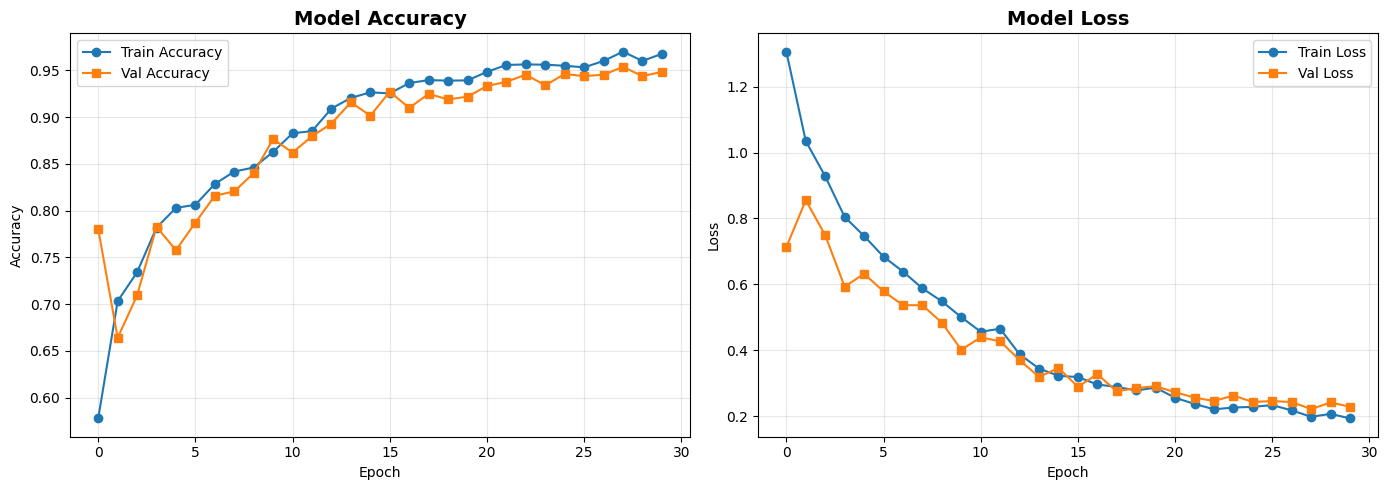

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss Plot
axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Val Loss', marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Saving the model

In [17]:
model.save("inceptionv3.keras")

#### Evaluation of the model

#### Confusion matrix, Classification report and Cohen Kappa Score

Found 1321 files belonging to 5 classes.
Classes: ['0_No_DR', '1_Mild_DR', '2_Moderate_DR', '3_Severe_DR', '4_Proliferative_DR']
Generating predictions...


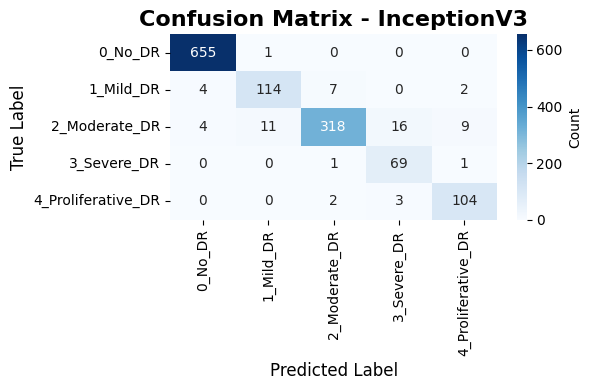


CLASSIFICATION REPORT
                    precision    recall  f1-score   support

           0_No_DR       0.99      1.00      0.99       656
         1_Mild_DR       0.90      0.90      0.90       127
     2_Moderate_DR       0.97      0.89      0.93       358
       3_Severe_DR       0.78      0.97      0.87        71
4_Proliferative_DR       0.90      0.95      0.92       109

          accuracy                           0.95      1321
         macro avg       0.91      0.94      0.92      1321
      weighted avg       0.96      0.95      0.95      1321


ACCURACY PER CLASS
0_No_DR: 99.85% (655/656)
1_Mild_DR: 89.76% (114/127)
2_Moderate_DR: 88.83% (318/358)
3_Severe_DR: 97.18% (69/71)
4_Proliferative_DR: 95.41% (104/109)

COHEN'S KAPPA SCORE
Kappa Score: 0.9304


In [ ]:
model = tf.keras.models.load_model('inceptionv3.keras')

img_size = (299, 299)  # InceptionV3 input size
batch_size = 32

val_ds = tf.keras.utils.image_dataset_from_directory(
    "val_dataset_clahe",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

class_names = val_ds.class_names
print(f"Classes: {class_names}")

def preprocess(images, labels):
    images = tf.cast(images / 255.0, tf.float32)
    return images, labels

val_ds = val_ds.map(preprocess).prefetch(tf.data.AUTOTUNE)

y_true = []
y_pred = []

print("Generating predictions...")
for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - InceptionV3', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))

# accuracy per class
print("\n" + "="*60)
print("ACCURACY PER CLASS")
print("="*60)
for i, class_name in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i].sum()
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name}: {class_accuracy*100:.2f}% ({class_correct}/{class_total})")

kappa_score = cohen_kappa_score(y_true, y_pred)
weighted_kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')

print("\n" + "="*60)
print("COHEN'S KAPPA SCORE")
print("="*60)
print(f"Kappa Score: {kappa_score:.4f}")
print("="*60)